In [1]:
import numpy as np
import pandas as pd

import astropy.constants as const
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
# plt.rcParams['text.usetex'] = True

from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline   # 三次样条插值

import os
path='./figs/'
os.makedirs(path,exist_ok=True) 

In [2]:
import scipy.interpolate as spip

# 理论公式

理论公式借用了 `astropy` 进行了带单位运算， 公式采用自然单位制。

In [3]:
def gamma_out_ratio(theta,omega_in):
    return 1/(1+omega_in/(const.m_e*const.c**2)*(1-np.cos(theta)))

def Klein_Nishin_formula(theta,omega):
    '''
    return d\\sigma/d\\cos(\\theta)
    '''
    
    omega_p_over_omega = gamma_out_ratio(theta,omega)
    diff_cross = np.pi*const.alpha**2/(const.m_e*const.c**2)**2*omega_p_over_omega**2*(omega_p_over_omega+1/omega_p_over_omega-np.sin(theta)**2)
    return (diff_cross*(const.h*const.c)**2).to(u.barn)
Cs137_Energy = 0.662*u.MeV

# 能谱定标

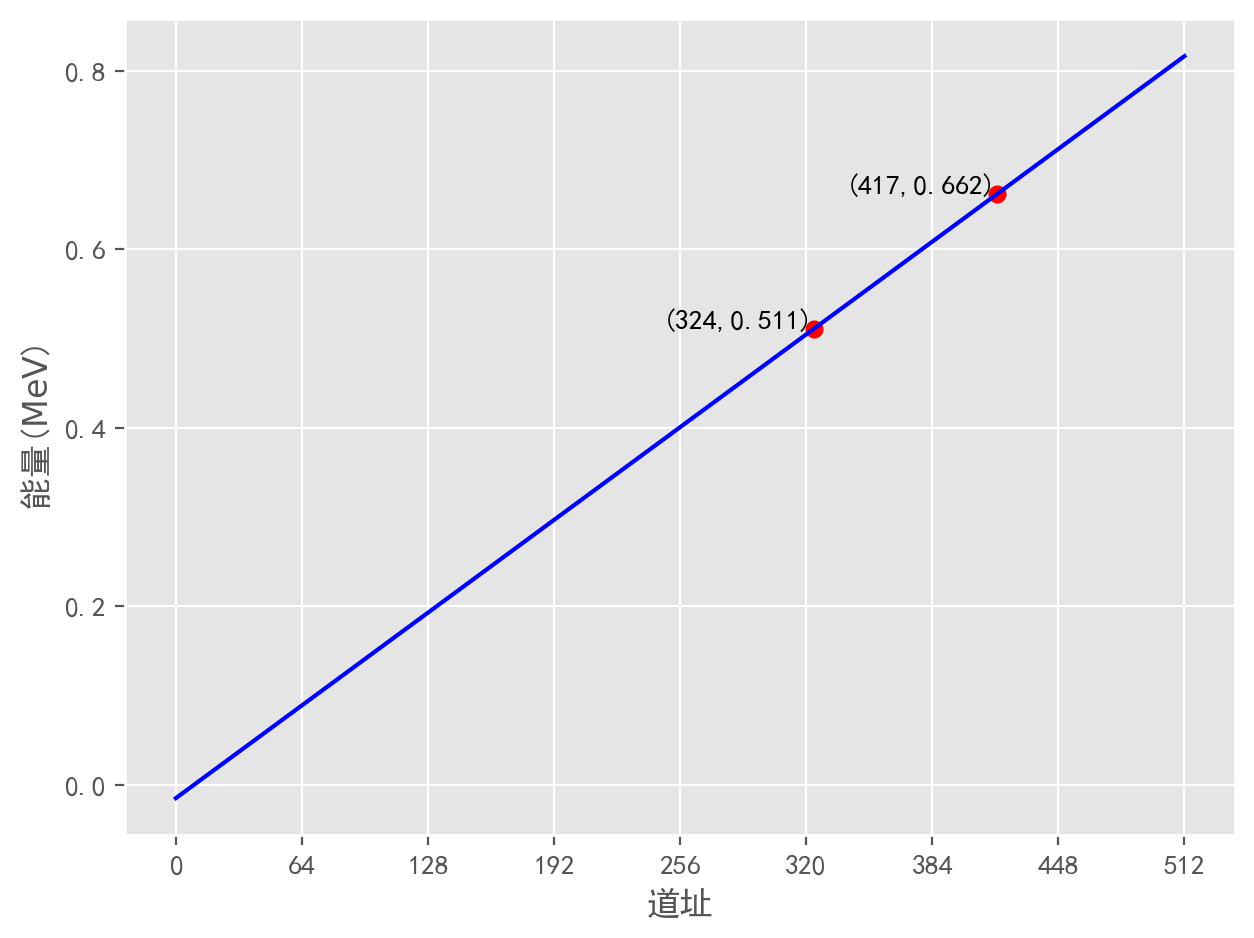

In [4]:
Ene = [0.662,0.511]
dao = [417,324]
dao_to_Ene = lagrange(dao,Ene)
x = np.linspace(0,512,512)
plt.plot(x,dao_to_Ene(x),'b')
plt.scatter(dao,Ene,c='r')
plt.text(dao[0],Ene[0],f'({dao[0]},{Ene[0]})',ha='right')
plt.text(dao[1],Ene[1],f'({dao[1]},{Ene[1]})',ha='right')
plt.xticks(np.linspace(0,512,9))
plt.xlabel('道址')
plt.ylabel(r'能量($\mathrm{MeV}$)')
plt.tight_layout()
plt.grid(True)
plt.savefig(path+'calibration.pdf')
plt.show()

# 探测效率插值

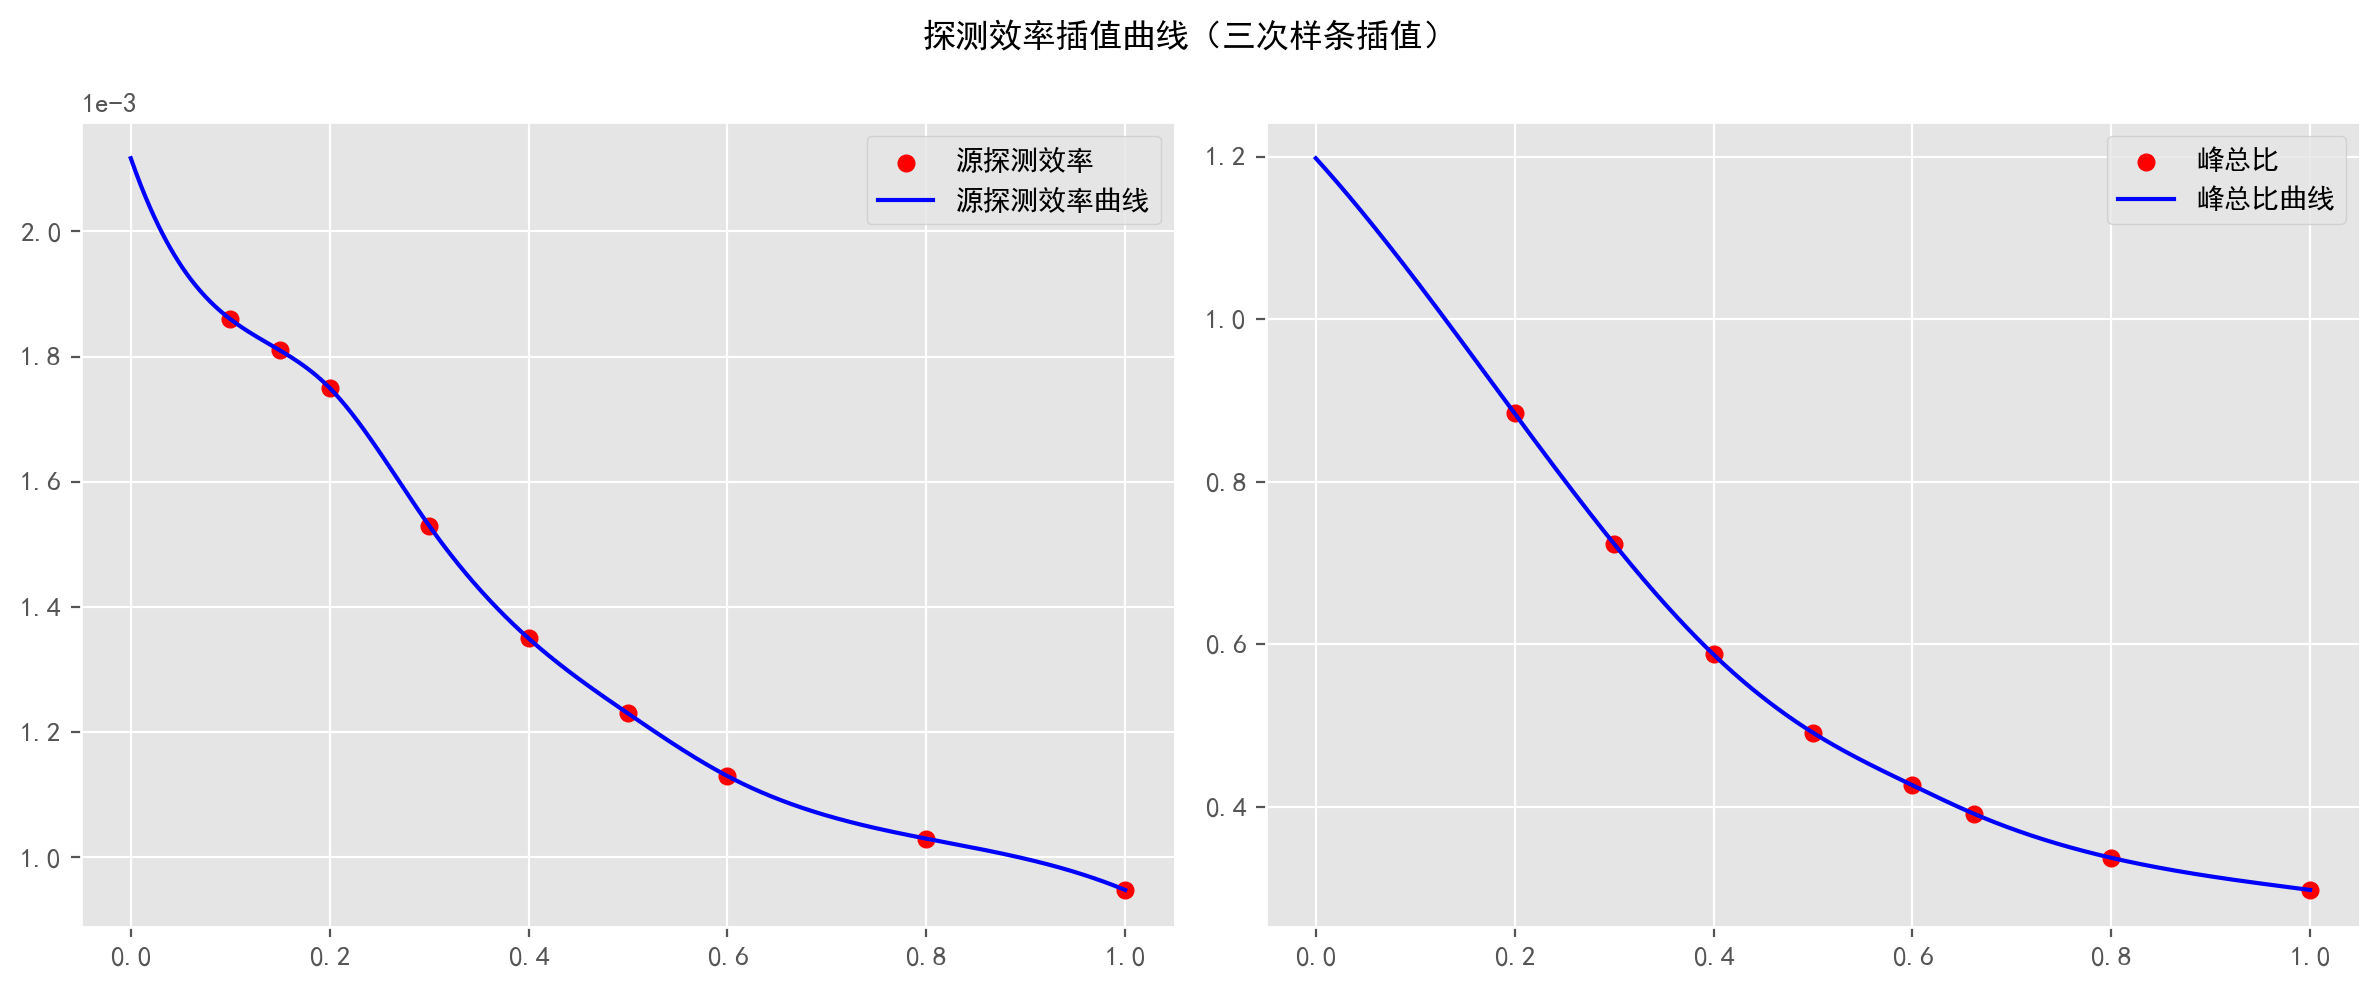

In [5]:
eta_data = pd.read_excel('detector efficience.xlsx',sheet_name='eta')
R_data = pd.read_excel('detector efficience.xlsx',sheet_name='R')

ene_to_eta = CubicSpline(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4))
ene_to_R = CubicSpline(R_data['E(MeV)'],R_data['R'])
# ene_to_eta = lagrange(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4))
# ene_to_R = lagrange(R_data['E(MeV)'],R_data['R'])

ene_plot = np.linspace(0,1,1001)
fig,ax=plt.subplots(1,2,figsize = (12,5))
ax[0].scatter(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4),
              c='r',label = '源探测效率')
ax[0].plot(ene_plot,ene_to_eta(ene_plot),
           c = 'b',label = '源探测效率曲线')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].legend()
ax[1].scatter(R_data['E(MeV)'],R_data['R'],
              c='r',label = '峰总比')
ax[1].plot(ene_plot,ene_to_R(ene_plot),
           c='b',label = '峰总比曲线')
ax[1].legend()
fig.suptitle('探测效率插值曲线（三次样条插值）')
fig.tight_layout()
fig.savefig(path+'interplo.pdf')

# 实验数据提取

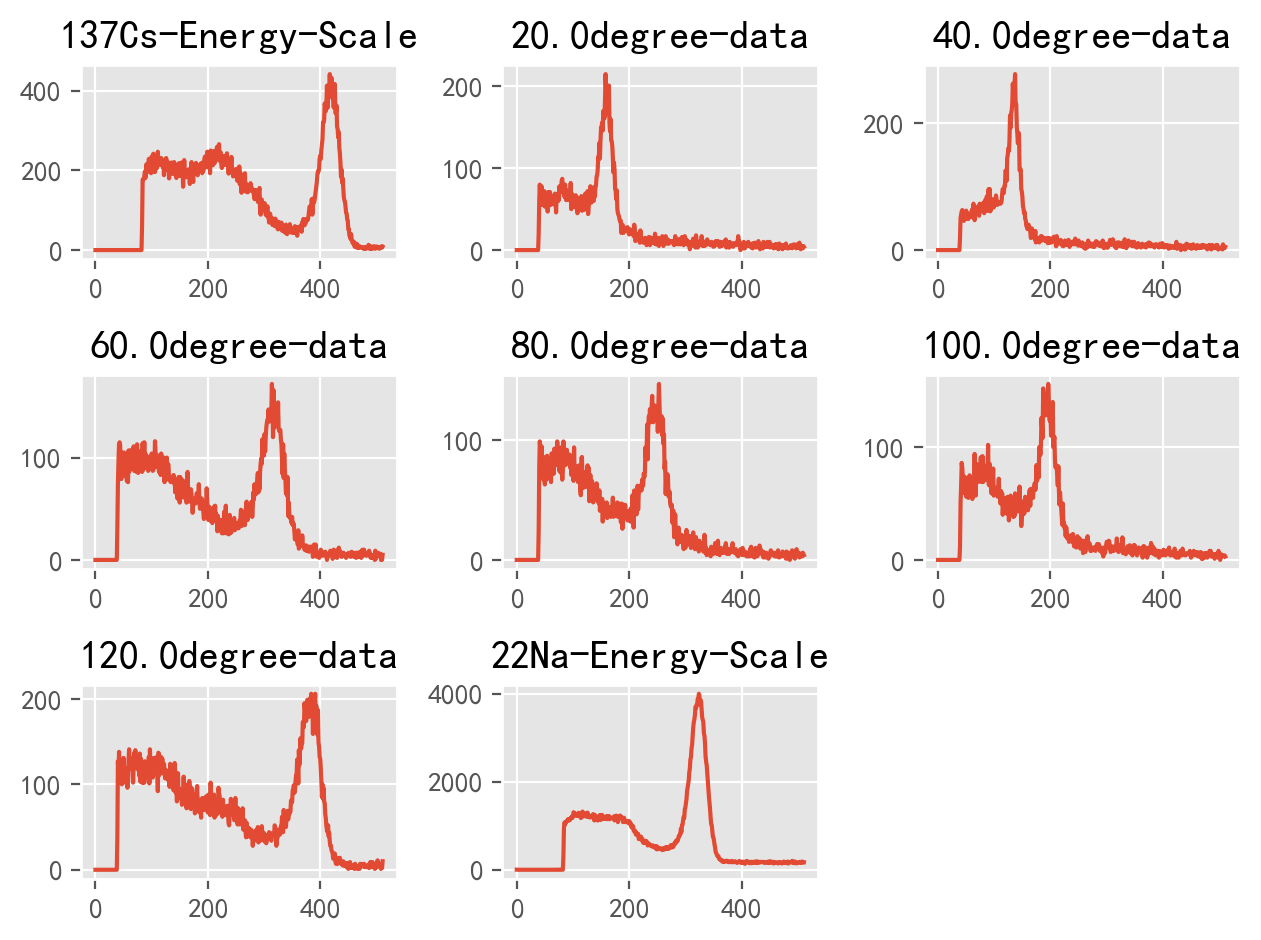

In [62]:
# pd.read_csv(txtfiles[0],sep=' ')
meanings = ['137Cs-Energy-Scale']+[f'{i}degree-data' for i in np.linspace(20,120,6)]+['22Na-Energy-Scale']
datas = [pd.read_csv(datapath+file, sep='\t')['1'].values for file in txtfiles]
datas = dict(zip(meanings,datas))

figs_per_line = 3
total_fig,total_axs = plt.subplots(figs_per_line,
                                   len(datas)//figs_per_line+int(bool(len(datas)%figs_per_line)))
total_axs = total_axs.flatten()
for i,(ax,data) in enumerate(zip(total_axs,datas)):
    ax.plot(datas[data])
    ax.set_title(data)

for ax in total_axs[i+1:]:
    ax.axis('off')

total_fig.tight_layout()


# ummm

[8.06282387 7.80046096 9.7472368  6.35285392 4.52770618 0.91327317]%


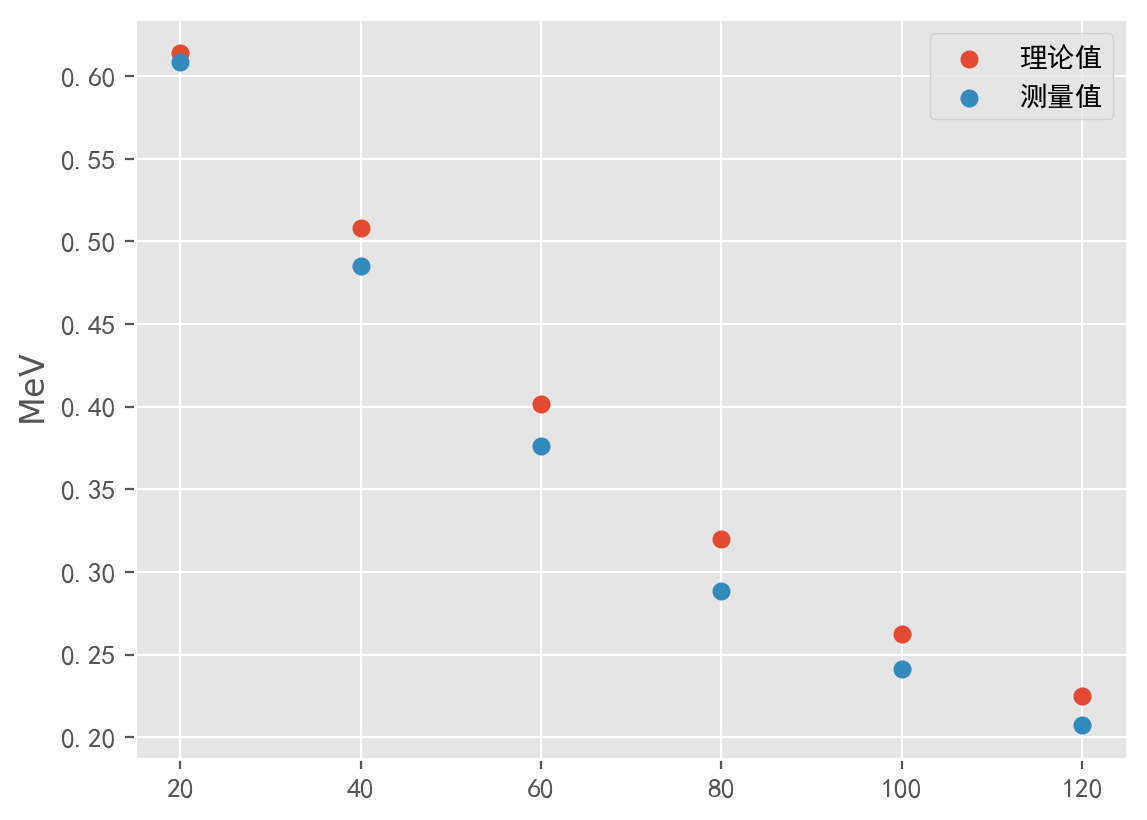

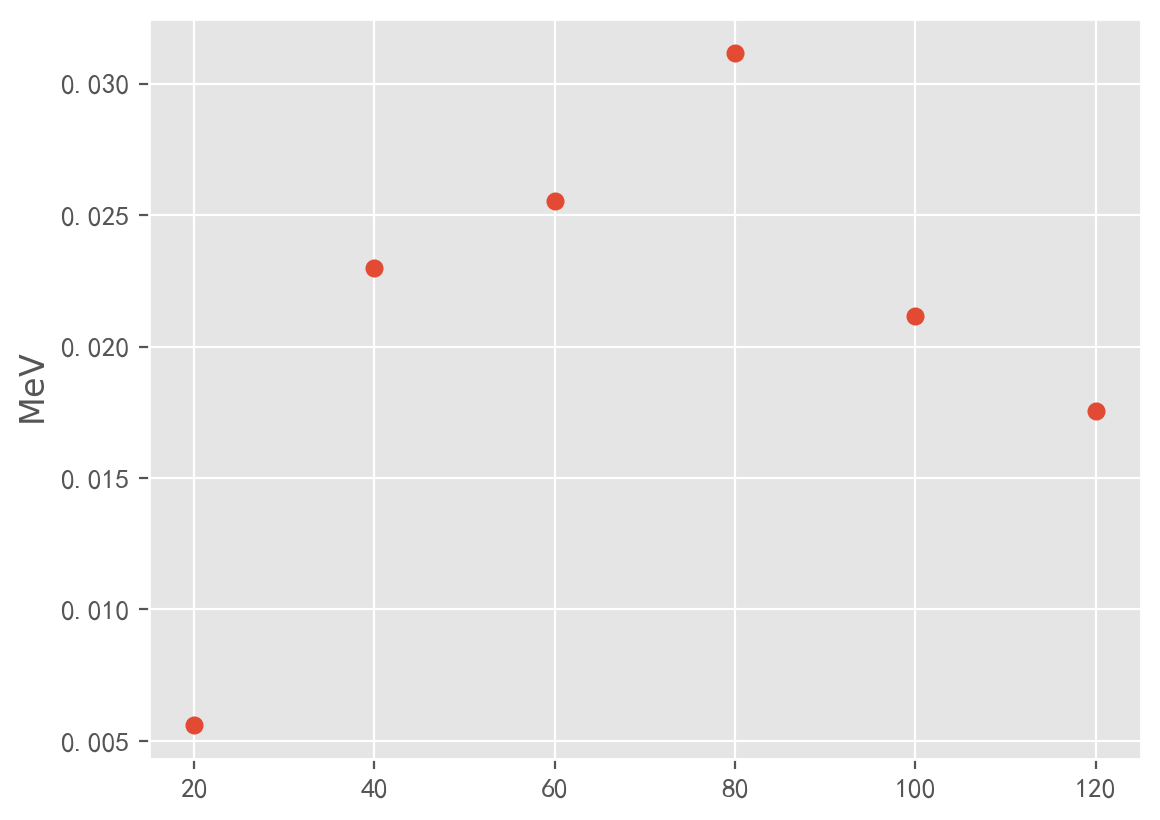

In [6]:
thetas = np.array([100,120,80,60,40,20])
daos = np.array([158,137,187,241,308,384])
theory_ene = gamma_out_ratio(thetas/180*np.pi,Cs137_Energy)*Cs137_Energy
measure_ene = dao_to_Ene(daos)*u.MeV
plt.scatter(thetas,theory_ene,label='理论值')
plt.scatter(thetas,measure_ene,label='测量值')
plt.legend()

error = np.abs(((theory_ene-measure_ene)/theory_ene).si.value)
print(error*100,end='%\n')
plt.show()
plt.scatter(thetas,theory_ene-measure_ene)
plt.show()

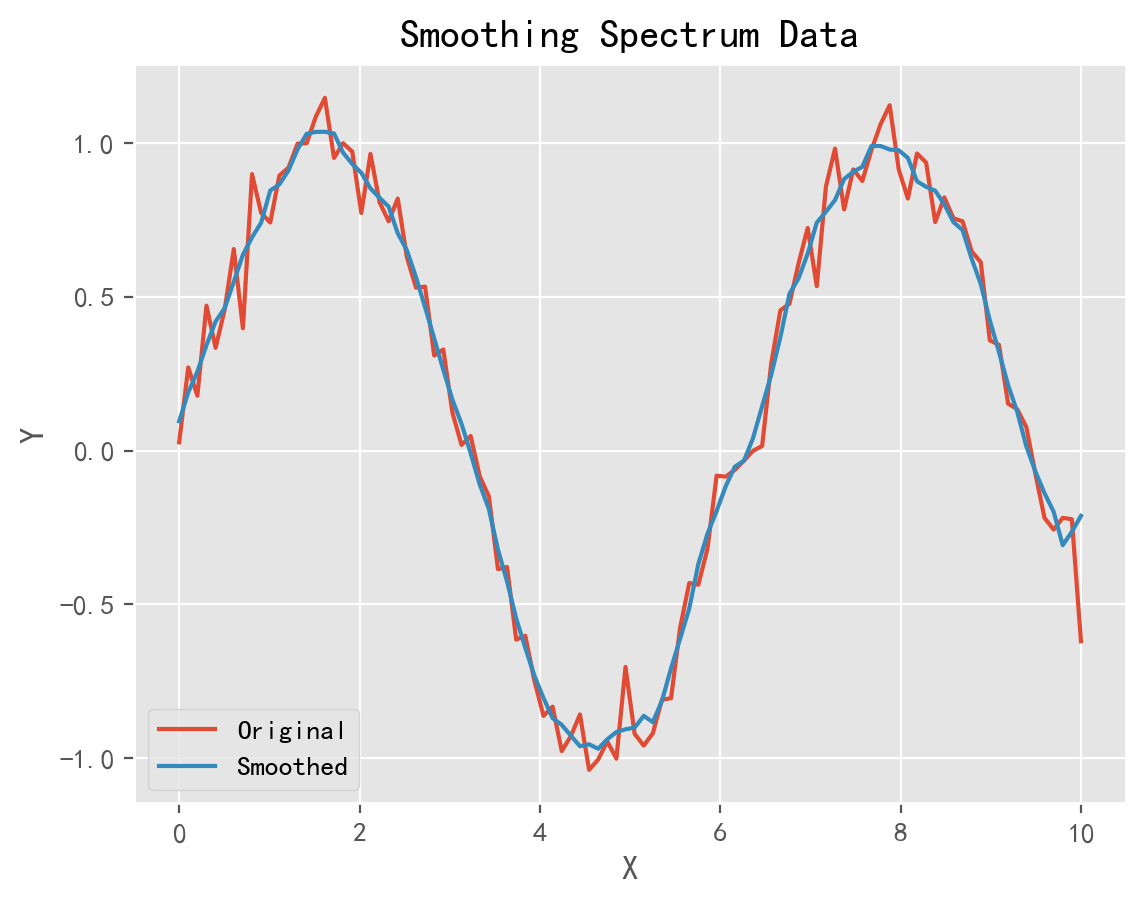

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这是原始的峰谱数据
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=100)

# 定义平滑窗口的大小
window_size = 5

# 定义平滑核，这里使用一个简单的移动平均滤波器
kernel = np.ones(window_size) / window_size

# 使用一维卷积对数据进行平滑处理
smoothed_y = np.convolve(y, kernel, mode='same')

# 绘制原始数据和平滑后的数据
plt.plot(x, y, label='Original')
plt.plot(x, smoothed_y, label='Smoothed')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Smoothing Spectrum Data')
plt.show()
